<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Google-Health/imaging-research/blob/master/cxr-foundation/CXR_Foundation_Demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/CXR_Foundation_Demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


# CXR Foundation Demo

This notebook demonstrates the richness of information contained in embeddings, generated from full Chest X-Ray images. The contents include how to:

- Download DICOM images and labels from the open-access NIH ChestX-ray14 dataset
- Use the CXR Foundation API to generate image embeddings from the DICOMs
- Train a simple neural network (WITHOUT needing GPU) to detect a medical finding in the embeddings

## Prerequisites

You must have access to use the CXR Foundation API. See the project's [README](https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/README.md) for details.

# [OPTIONAL] Set up Colab to run locally

If you want to run this Colab on your local files, follow the instructions here!

1. Create a Python virtual environment, a local directory that contains all of the dependencies your code needs to run:

        python -m venv env
        source env/bin/activate

2. Install Jupyter and enable the Colab extension (see https://research.google.com/colaboratory/local-runtimes.html):

        pip install jupyter
        pip install jupyter_http_over_ws
        jupyter serverextension enable --py jupyter_http_over_ws
        jupyter notebook \
            --NotebookApp.allow_origin='https://colab.research.google.com' \
            --port=8888 \
            --NotebookApp.port_retries=0

3. In the output of this command, there will be a link that looks like:

        http://localhost:8888/?token=abc12345

  4. Click the the arrow next to "Connect" in the upper right of this screen.
  5. Select "Connect to a local runtime"
  6. Paste the link from the output of the command above.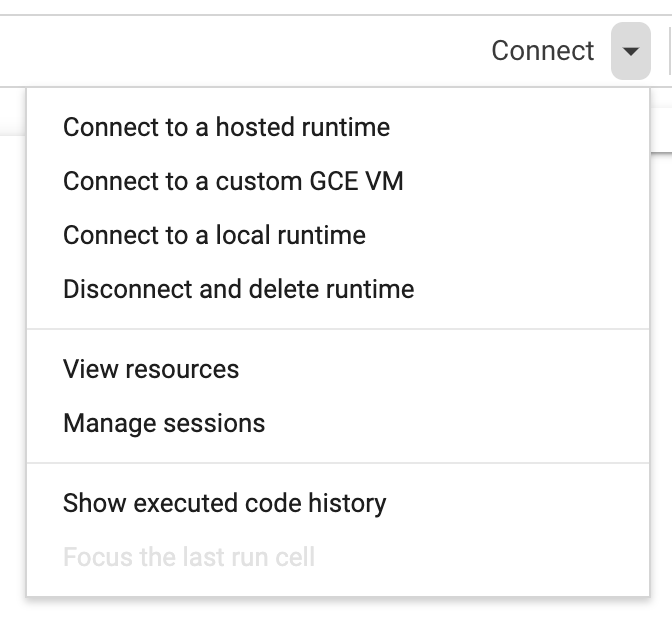

# Installation

Install the CXR Foundation Python Library

In [1]:
!git clone https://github.com/Google-Health/imaging-research.git
!pip install imaging-research/cxr-foundation/

Cloning into 'imaging-research'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 348 (delta 48), reused 41 (delta 26), pack-reused 274
Receiving objects: 100% (348/348), 304.14 KiB | 4.61 MiB/s, done.
Resolving deltas: 100% (184/184), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./imaging-research/cxr-foundation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.3 MB/s eta 

*Did you restart the runtime?*

If you are using Google Colab, the runtime must be restarted after installing new packages.

NOTE: You will have some ERROR messages due to the protobuf library - this is normal.

# Download Data

The NIH ChestX-ray14 dataset, consists of over 100,000 de-identified images of chest x-rays, with fourteen common disease labels, text-mined from the text radiological reports via NLP techniques. The dataset is available on the NIH [download site](https://nihcc.app.box.com/v/ChestXray-NIHCC) and on [Google Cloud](https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest).

The CXR Foundation Demo GCS [bucket](https://console.cloud.google.com/storage/browser/cxr-foundation-demo) contains a subset of the data. We will download the dataset's labels file and some DICOM images below. This might take ~10 minutes or so depending on your connection speed.

In [1]:
import glob
import io
import os

from google.colab import auth
from google.cloud import storage
import pandas as pd

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [2]:
# Make a directory to download the data
if not os.path.exists('data'):
  os.mkdir('data')

# Initialize the GCS storage client
storage_client = storage.Client()
bucket = storage_client.get_bucket('cxr-foundation-demo')

# Download and inspect the labels file.
# There is a column for each of several findings, which indicate whether or not
# the condition is present in the image file.
full_labels_df = pd.read_csv(io.BytesIO(bucket.blob('cxr14/labels.csv').download_as_string()))
full_labels_df['filename'] = full_labels_df['image_id'].apply(lambda x: os.path.join('cxr14', 'inputs', x.replace('.png', '.dcm')))
display(full_labels_df.head())

,image_id,patient_id,case_id,split,AIRSPACE_OPACITY,FRACTURE,PNEUMOTHORAX,CONSOLIDATION,EFFUSION,PULMONARY_EDEMA,ATELECTASIS,CARDIOMEGALY,filename
0,00004850_004.png,4850,4,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00004850_004.dcm
1,00007962_001.png,7962,1,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00007962_001.dcm
2,00008682_000.png,8682,0,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00008682_000.dcm
3,00018739_006.png,18739,6,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00018739_006.dcm
4,00019255_000.png,19255,0,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00019255_000.dcm


In [3]:
# Download the DICOM files, organized by the AIRSPACE_OPACITY label.
# Download up to 100 of each case: positive and negative
FINDING = 'AIRSPACE_OPACITY' #@param {type: 'string'}
MAX_CASES_PER_CATEGORY = 100 #@param {type: 'integer'}
OUTPUT_DIR = './data/outputs' #@param {type: 'string'}
INPUT_DIR = './data/inputs' #@param {type: 'string'}

for label, label_name in [(0, 'negative'), (1, 'positive')]:
  directory = os.path.join(INPUT_DIR, f'{FINDING}_{label_name}')
  if not os.path.exists(directory):
    os.makedirs(directory)

  for i, fname in enumerate(full_labels_df[full_labels_df[FINDING] == label]['filename'].values):
    if i > MAX_CASES_PER_CATEGORY:
      print(f'Downloaded {MAX_CASES_PER_CATEGORY} DICOMs with {FINDING} == {label}')
      break
    blob = bucket.blob(fname)
    if blob.exists():
      blob.download_to_filename(os.path.join(directory, os.path.basename(blob.name)))

Downloaded 100 DICOMs with AIRSPACE_OPACITY == 0
Downloaded 100 DICOMs with AIRSPACE_OPACITY == 1


# Create a labels file of the downloaded DICOMs

Create a labels CSV file using the directory structure of the downloaded files. The DICOM images in the `AIRSPACE_OPACITY_negative` folder will have a label of 0 and the ones in the `AIRSPACE_OPACITY_positive` folder will have a label of 1.

This will be used later for model training.

In [7]:
labels_df = pd.DataFrame(glob.glob(os.path.join(INPUT_DIR, '*/*.dcm')), columns=['image_id'])
labels_df[FINDING] = labels_df['image_id'].apply(lambda x: int('positive' in x))

display(labels_df.head())

,image_id,AIRSPACE_OPACITY
0,./data/inputs/AIRSPACE_OPACITY_negative/000185...,0
1,./data/inputs/AIRSPACE_OPACITY_negative/000281...,0
2,./data/inputs/AIRSPACE_OPACITY_negative/000171...,0
3,./data/inputs/AIRSPACE_OPACITY_negative/000262...,0
4,./data/inputs/AIRSPACE_OPACITY_negative/000187...,0


# Generate Embeddings

**IMPORTANT:** You must have access to use the CXR Foundation API. See the project's [README](https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/README.md) for details.

Generate embeddings (think of them as compressed images) from the downloaded DICOMs. This may take ~15 minutes depending on the load on the server and your connection speed. There may be some warnings about "Could not load dynamic library" and or "No project ID could be determined," but these can be safely ignored.



In [8]:
!python -m cxr_foundation.run_inference \
  --input_path "{INPUT_DIR}/*/*.dcm" \
  --output_path "{OUTPUT_DIR}" \
  --input_file_type='dicom' \
  --limit -1  # setting this flag to -1 means unlimited

2023-04-27 20:52:14.542049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 20:52:16.666307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-27 20:52:16.666548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-27 20:52:16.666575: W tensorfl

Examine one of the output files:

In [9]:
import tensorflow as tf

raw_dataset = tf.data.TFRecordDataset(glob.glob(os.path.join(OUTPUT_DIR, '*.tfrecord')))
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "embedding"
    value {
      float_list {
        value: -0.004238147754222155
        value: -2.6776785850524902
        value: 1.618560791015625
        value: -1.3356856107711792
        value: -0.07146406918764114
        value: 0.5542863607406616
        value: 0.19705604016780853
        value: 0.18047645688056946
        value: 2.65290904045105
        value: 1.1525002717971802
        value: -0.3968721628189087
        value: 0.3657768666744232
        value: -0.2212032824754715
        value: 0.08019044995307922
        value: 2.3461153507232666
        value: 2.0055229663848877
        value: -0.6669224500656128
        value: -0.02794334851205349
        value: -0.19013738632202148
        value: -0.0642712414264679
        value: 2.243643045425415
        value: 1.9042776823043823
        value: -2.776141405105591
        value: 1.4811410903930664
        value: -2.315427303314209
        value: 1.3885436058044434
        value: -1.607033729

In [10]:
# Note that the 'image/id' feature within the tf.Example is set to the input filename.
# This is the image identifier whose value was specified in the labels CSV created earlier.
example.features.feature['image/id'].bytes_list.value[0]

b'./data/inputs/AIRSPACE_OPACITY_positive/00022600_001.dcm'

# Prepare Data for Model Training

Separate into training, validation, and testing sets.

Since we don't have a dedicated train/validation split, we can just hold out 10% of our data to create a validation set.

In [11]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(labels_df, test_size=0.1)
train_df['split'] = 'train'
validate_df['split'] = 'validate'
labels_df = pd.concat([train_df, validate_df])

# Save the DataFrame as a CSV file
labels_df.to_csv('./data/labels.csv')

display(labels_df.head())

,image_id,AIRSPACE_OPACITY,split
86,./data/inputs/AIRSPACE_OPACITY_negative/000132...,0,train
145,./data/inputs/AIRSPACE_OPACITY_positive/000173...,1,train
170,./data/inputs/AIRSPACE_OPACITY_positive/000214...,1,train
0,./data/inputs/AIRSPACE_OPACITY_negative/000185...,0,train
144,./data/inputs/AIRSPACE_OPACITY_positive/000049...,1,train


# Train our model

Finally, we can train our model! It should take < 5 minutes to train 100 epochs!

In [12]:
!python -m cxr_foundation.train \
  --data_dir {OUTPUT_DIR} \
  --labels_csv ./data/labels.csv \
  --head_name {FINDING} \
  --train_label train \
  --validate_label validate \
  --save_model_name "{OUTPUT_DIR}/model" \
  --num_epochs 100

2023-04-27 21:20:10.594315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-27 21:20:10.594446: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-27 21:20:10.594471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Ad

In [13]:
# Load the saved model and show the model summary
model = tf.keras.models.load_model(os.path.join(OUTPUT_DIR, 'model'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/layers/core/lambda_layer.py:324: UserWarning: cxr_foundation.train_lib is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1376)]            0         
                                                                 
 dense (Dense)               (None, 512)               705024    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             

In [14]:
# Compile the model to use it
model.compile()

# Examine metrics

In [15]:
import sklearn
import matplotlib.pyplot as plt

def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)

In [16]:
from cxr_foundation import train_lib

file_names = glob.glob(os.path.join(OUTPUT_DIR, '*.tfrecord'))
validate_labels = dict(zip(validate_df['image_id'], validate_df[FINDING].astype(int)))
validation_data = (
    train_lib.get_dataset(file_names, labels=validate_labels).batch(1).cache()
)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:
rows = []
for embeddings, label, weight in validation_data:
  row = {
      f'{FINDING}_prediction': model(embeddings)[FINDING].numpy().flatten()[0],
      f'{FINDING}_weight': weight.numpy().flatten()[0],
      f'{FINDING}_value': label.numpy().flatten()[0]
  }
  rows.append(row)
eval_df = pd.DataFrame(rows)

In [31]:
eval_df.head()

,AIRSPACE_OPACITY_prediction,AIRSPACE_OPACITY_weight,AIRSPACE_OPACITY_value
0,0.990839,1.0,1
1,0.460471,1.0,1
2,0.931159,1.0,1
3,0.362252,1.0,0
4,0.590535,1.0,1


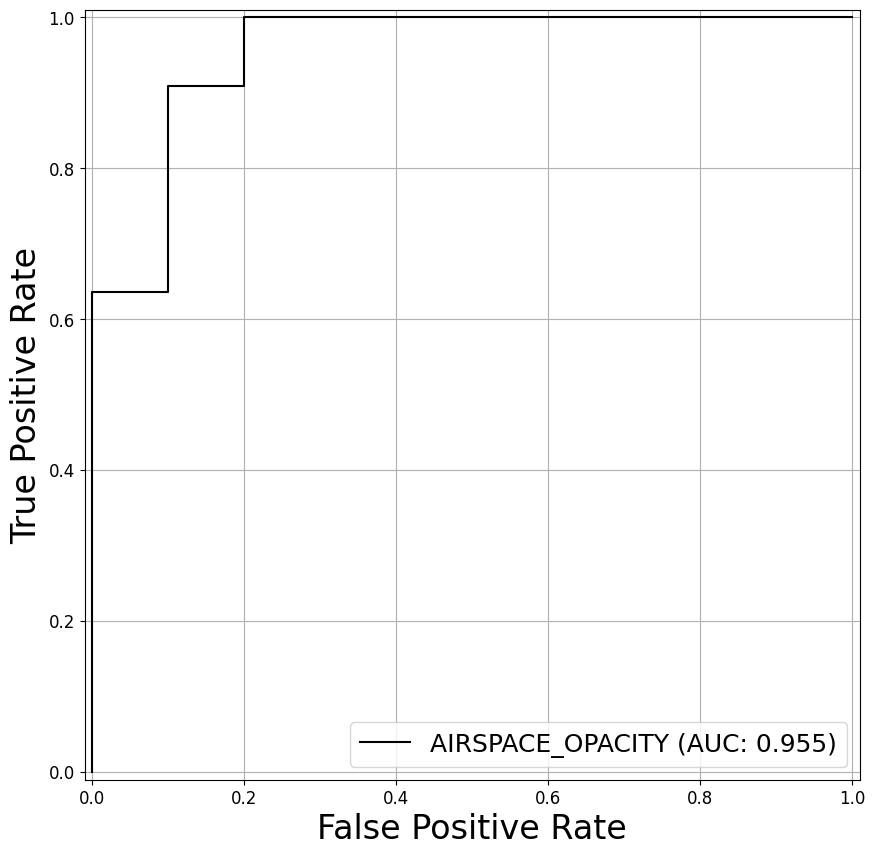

In [36]:
labels = eval_df[f'{FINDING}_value'].values
predictions = eval_df[f'{FINDING}_prediction'].values
weights = eval_df[f'{FINDING}_weight'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions, sample_weight=weights)
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label=FINDING)